# Exercise 1: Heat Conduction for multiple layers with variable properties

The development of the temperature field for an arbitrary building component should be calculated. The component can consist of multiple layers with varying properties. Furthermore, the gridsizes may very in the different layers.
<img alt="Arbitrary building component with n layers and prescribed boundary conditions." height="250" src="building_comp.png" title="Depiciton" width="250"/>


In [27]:
import matplotlib.pyplot as plt
import numpy as np

First we are going to create some classes to easier describe the problem.
- Cell_Mat: This class should resemble a certain martial, with the needed properties to define needed for the calculation.
- Boundary_Cell: Class for the boundary layer. This one only has a temperature and a given resistance.
- We will not create a class for the simulation, because this would clutter the notebook. Feel free to do so on your own.

In [28]:
class Cell_Mat(object):
    def __init__(self, *args, **kwargs):
        # Discretization
        self.dx = kwargs.get('dx', None)
        self.face_e = kwargs.get('face_e', None)
        self.face_w = kwargs.get('face_w', None)

        # Material parameters
        self.lamb = kwargs.get('lamb', None)
        self.cp = kwargs.get('cp', None)
        self.rho = kwargs.get('rho', None)
        self.RC = self.dx / self.lamb

        # Fields
        self.Tn = kwargs.get('Tn', None)
        self.Tn_plus = kwargs.get('Tn_plus', None)
        self.dT = kwargs.get('dT', None)

        # Neighbours
        self.cell_E = kwargs.get('cell_E', None)
        self.cell_W = kwargs.get('cell_W', None)


class Boundary_Cell(object):
    def __init__(self, *args, **kwargs):
        # Fields
        self.Tn = kwargs.get('Tn', None)
        self.Tn_plus = kwargs.get('Tn_plus', None)

        self.RC = kwargs.get('RC', None)

        # Neighbours
        # No neighbours. This is the end of the sim domain

Here we create our input data for our calculation:

In [29]:
# ----------------------------------
# Define simulation domain
# ----------------------------------

# Define Simulation parameters
sim_time = 3600 * 24 * 1

# Define mat cells
eps = [0] * 20
eps = [Cell_Mat(dx=0.01, lamb=0.04, cp=1470, rho=1000, Tn=10) for i in eps]
concrete = [0] * 10
concrete = [Cell_Mat(dx=0.015, lamb=2.3, cp=1000, rho=2500, Tn=10) for i in concrete]
plaster = [0] * 4
plaster = [Cell_Mat(dx=0.005, lamb=0.9, cp=1000, rho=2000, Tn=10) for i in plaster]

# Define BCs
BC_left = [Boundary_Cell(Tn=0, RC=0.04)]
BC_right = [Boundary_Cell(Tn=20, RC=0.10)]

# Assemble simulation domain
layers = [eps, concrete, plaster]
mat_domain = eps + concrete + plaster
whole_domain = BC_left + mat_domain + BC_right
num_cells = whole_domain.__len__()

Next we are going to assemble the matrices for calculation:

In [30]:
#  Assemble Sim domain into matrices
# Initialise variables

# Apply neighbours
for count, cell in enumerate(mat_domain):
    cell.cell_W = whole_domain[count]
    cell.cell_E = whole_domain[count + 2]

# %%
dx_array = np.array([cell.dx for cell in mat_domain])

Tn = np.array([cell.Tn for cell in whole_domain])
Tn_plus = np.array([cell.Tn_plus for cell in whole_domain])
# get interface indices
interface_indices = [layer.__len__() for layer in layers]  # here the ghost cells are missing.
RC_array = np.array([cell.RC for cell in whole_domain])
RC_W = RC_array[0:-2]
RC_P = RC_array[1:-1]
RC_E = RC_array[2:]
Kw_array = 1 / (RC_W / 2 + RC_P / 2)
Ke_array = 1 / (RC_E / 2 + RC_P / 2)

# Build conductivity matrix [K]
# Create sparse matrix
Left_diagonal = np.eye(num_cells, num_cells, k=-1)
Left_diagonal[1:-1, 0:-2] = Left_diagonal[1:-1, 0:-2] * Kw_array
Right_diagonal = np.eye(num_cells, num_cells, k=1)
Right_diagonal[1:-1, 2:] = Right_diagonal[1:-1, 2:] * Ke_array
Main_Diagonal = np.eye(num_cells, num_cells)
Main_Diagonal[1:-1, 1:-1] = Main_Diagonal[1:-1, 1:-1] * - (Kw_array + Ke_array)
K = Left_diagonal + Main_Diagonal + Right_diagonal
# Multiply with constants
cp_array = np.array([cell.cp for cell in mat_domain])
Left_diagonal = np.eye(num_cells, num_cells, k=-1)
Left_diagonal[1:-1, 0:-2] = Left_diagonal[1:-1, 0:-2] * cp_array
Right_diagonal = np.eye(num_cells, num_cells, k=1)
Right_diagonal[1:-1, 2:] = Right_diagonal[1:-1, 2:] * cp_array
Main_Diagonal = np.eye(num_cells, num_cells)
Main_Diagonal[1:-1, 1:-1] = Main_Diagonal[1:-1, 1:-1] * cp_array
cp_P_constants = Left_diagonal + Main_Diagonal + Right_diagonal
cp_P_constants[cp_P_constants == 0] = 1

rho_array = np.array([cell.rho for cell in mat_domain])
Left_diagonal = np.eye(num_cells, num_cells, k=-1)
Left_diagonal[1:-1, 0:-2] = Left_diagonal[1:-1, 0:-2] * rho_array
Right_diagonal = np.eye(num_cells, num_cells, k=1)
Right_diagonal[1:-1, 2:] = Right_diagonal[1:-1, 2:] * rho_array
Main_Diagonal = np.eye(num_cells, num_cells)
Main_Diagonal[1:-1, 1:-1] = Main_Diagonal[1:-1, 1:-1] * rho_array
rho_P_constants = Left_diagonal + Main_Diagonal + Right_diagonal
rho_P_constants[rho_P_constants == 0] = 1

Left_diagonal = np.eye(num_cells, num_cells, k=-1)
Left_diagonal[1:-1, 0:-2] = Left_diagonal[1:-1, 0:-2] * dx_array
Right_diagonal = np.eye(num_cells, num_cells, k=1)
Right_diagonal[1:-1, 2:] = Right_diagonal[1:-1, 2:] * dx_array
Main_Diagonal = np.eye(num_cells, num_cells)
Main_Diagonal[1:-1, 1:-1] = Main_Diagonal[1:-1, 1:-1] * dx_array
dx_P_constants = Left_diagonal + Main_Diagonal + Right_diagonal
dx_P_constants[dx_P_constants == 0] = 1

## Simulation
As heard in the lecture, we are going to use an explicit Euler scheme. Since we have created a linear equation system for our problem we can solve the whole domain each step with a simple matrix multiplication.

Before running the loop we will check for a suitable timestep with the Fourier Number.

In [31]:
# ----------------------
# Simulation
# ----------------------
t = 0
smallest_dx = dx_array.min()
smallest_cp = cp_array.min()
smallest_rho = rho_array.min()
lamb_array = np.array([cell.lamb for cell in mat_domain])
biggest_lamb = lamb_array.max()
dt = 0.5 * smallest_cp * smallest_rho * smallest_dx ** 2 / biggest_lamb

Now we can multiply our conductivity matrix with the missing constants:

In [32]:
# Multiply [K] with constants
K = K / cp_P_constants / rho_P_constants / dx_P_constants * dt
K[0, 0], K[0, 1], K[-1, -1], K[-1, -2] = 0, 0, 0, 0  # ghost lines for boundary conditions
# Rewrite [K] * [T] + [T] with identitiy matrix
I = np.eye(num_cells, num_cells)
L = I + K


And finally run our simulation.

In [33]:
# Simulation Loop
while t <= sim_time:
    # Calculate temperature field
    # ------------------------------
    # Tn_plus = K @ Tn + Tn
    Tn_plus = L @ Tn
    Tn = Tn_plus
    t += dt

Let's plot our results.

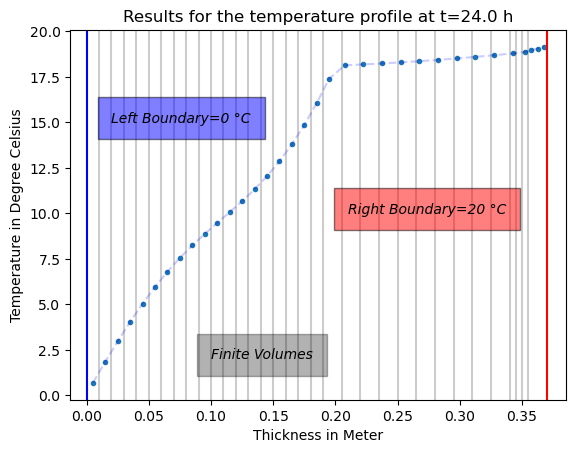

In [34]:
#  Plot tempfield to check
dx_array = np.array([cell.dx for cell in mat_domain])
d_array = np.cumsum(dx_array) - dx_array/2

plt.plot(d_array, Tn[1:-1], '.')
plt.plot(d_array, Tn[1:-1], linestyle='dashed', alpha = 0.2, color='b')
# plt.xticks(np.arange(min(d_array), max(d_array), 0.01))
for x in np.cumsum(dx_array[1:-1]):
    plt.axvline(x, alpha=0.2, color='black')
plt.axvline(0, alpha=1, color='blue')
plt.axvline(np.cumsum(dx_array)[-1], alpha=1, color='red')
plt.annotate(xy=(10, 10), text='Left Boundary', fontsize=22)
# plt.text(-5, 60, 'Right Boundary', fontsize=22)
plt.text(0.02, 15, f'Left Boundary={BC_left[0].Tn} °C', style='italic', bbox={
    'facecolor': 'blue', 'alpha': 0.5, 'pad': 10})
plt.text(0.21, 10, f'Right Boundary={BC_right[0].Tn} °C', style='italic', bbox={
    'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
plt.text(0.10, 2, 'Finite Volumes', style='italic', bbox={
    'facecolor': 'black', 'alpha': 0.3, 'pad': 10})
plt.title(f'Results for the temperature profile at t={sim_time/3600} h')

plt.xlabel('Thickness in Meter')
plt.ylabel('Temperature in Degree Celsius')
plt.show()